## load data, clip to land

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from scipy.stats import mannwhitneyu
import pandas as pd
import matplotlib.lines as mlines
# plt.rcParams.update({'font.size': 12})

In [2]:
datapath = f'/g/data/ng72/as9583/cylc-run/u-dr216/netcdf_new'
variable = 'soil_moisture_l1'
SM_level = 'Level 1'

experiment1 = 'drysoil_d0198_RAL3P2_albedo_bare_' 
allvar = xr.open_dataset(f'{datapath}/{variable}/{experiment1}{variable}.nc')['moisture_content_of_soil_layer']

experiment2 = 'control_d0198_RAL3P2_' 
control = xr.open_dataset(f'{datapath}/{variable}/{experiment2}{variable}.nc')['moisture_content_of_soil_layer']

experiment3 = 'control_d0198_RAL3P2_albedo_bare_'
albedo_bare = xr.open_dataset(f'{datapath}/{variable}/{experiment3}{variable}.nc')['moisture_content_of_soil_layer']

experiment4 = 'control_d0198_RAL3P2_albedo_'
albedo = xr.open_dataset(f'{datapath}/{variable}/{experiment4}{variable}.nc')['moisture_content_of_soil_layer']

experiment5 = 'control_d0198_RAL3P2_bare_'
bare = xr.open_dataset(f'{datapath}/{variable}/{experiment5}{variable}.nc')['moisture_content_of_soil_layer']

experiment6 = 'drysoil_d0198_RAL3P2_albedo_'
SM_albedo = xr.open_dataset(f'{datapath}/{variable}/{experiment6}{variable}.nc')['moisture_content_of_soil_layer']

experiment7 = 'drysoil_d0198_RAL3P2_bare_'
SM_bare = xr.open_dataset(f'{datapath}/{variable}/{experiment7}{variable}.nc')['moisture_content_of_soil_layer']

experiment8 = 'drysoil_d0198_RAL3P2_'
SM = xr.open_dataset(f'{datapath}/{variable}/{experiment8}{variable}.nc')['moisture_content_of_soil_layer']

In [3]:
fires = gpd.read_file('/g/data/ng72/as9583/merged_fires.gpkg')
variable2 = 'surface_altitude'
sa1 = xr.open_dataset(f'{datapath}/{variable2}/{experiment1}{variable2}.nc')[variable2].isel(time=0)

In [4]:
#clip to land only
variable3 = 'land_sea_mask'
landmask = xr.open_dataset(f'{datapath}/{variable3}/{experiment1}{variable3}.nc')["land_binary_mask"].isel(time=0)
allvar = allvar.where(landmask == 1)
control = control.where(landmask == 1)
albedo_bare = albedo_bare.where(landmask == 1)
albedo = albedo.where(landmask == 1)
bare = bare.where(landmask == 1)
SM_albedo = SM_albedo.where(landmask == 1)
SM_bare = SM_bare.where(landmask == 1)
SM = SM.where(landmask == 1)

## mean 

In [5]:
#mean over time
allvar_total = allvar.mean(dim='time', skipna=True)
control_total = control.mean(dim='time', skipna=True)
albedo_bare_total = albedo_bare.mean(dim='time', skipna=True)
albedo_total = albedo.mean(dim='time', skipna=True)
bare_total = bare.mean(dim='time', skipna=True)
SM_albedo_total = SM_albedo.mean(dim='time', skipna=True) 
SM_bare_total = SM_bare.mean(dim='time', skipna=True)
SM_total = SM.mean(dim='time', skipna=True)

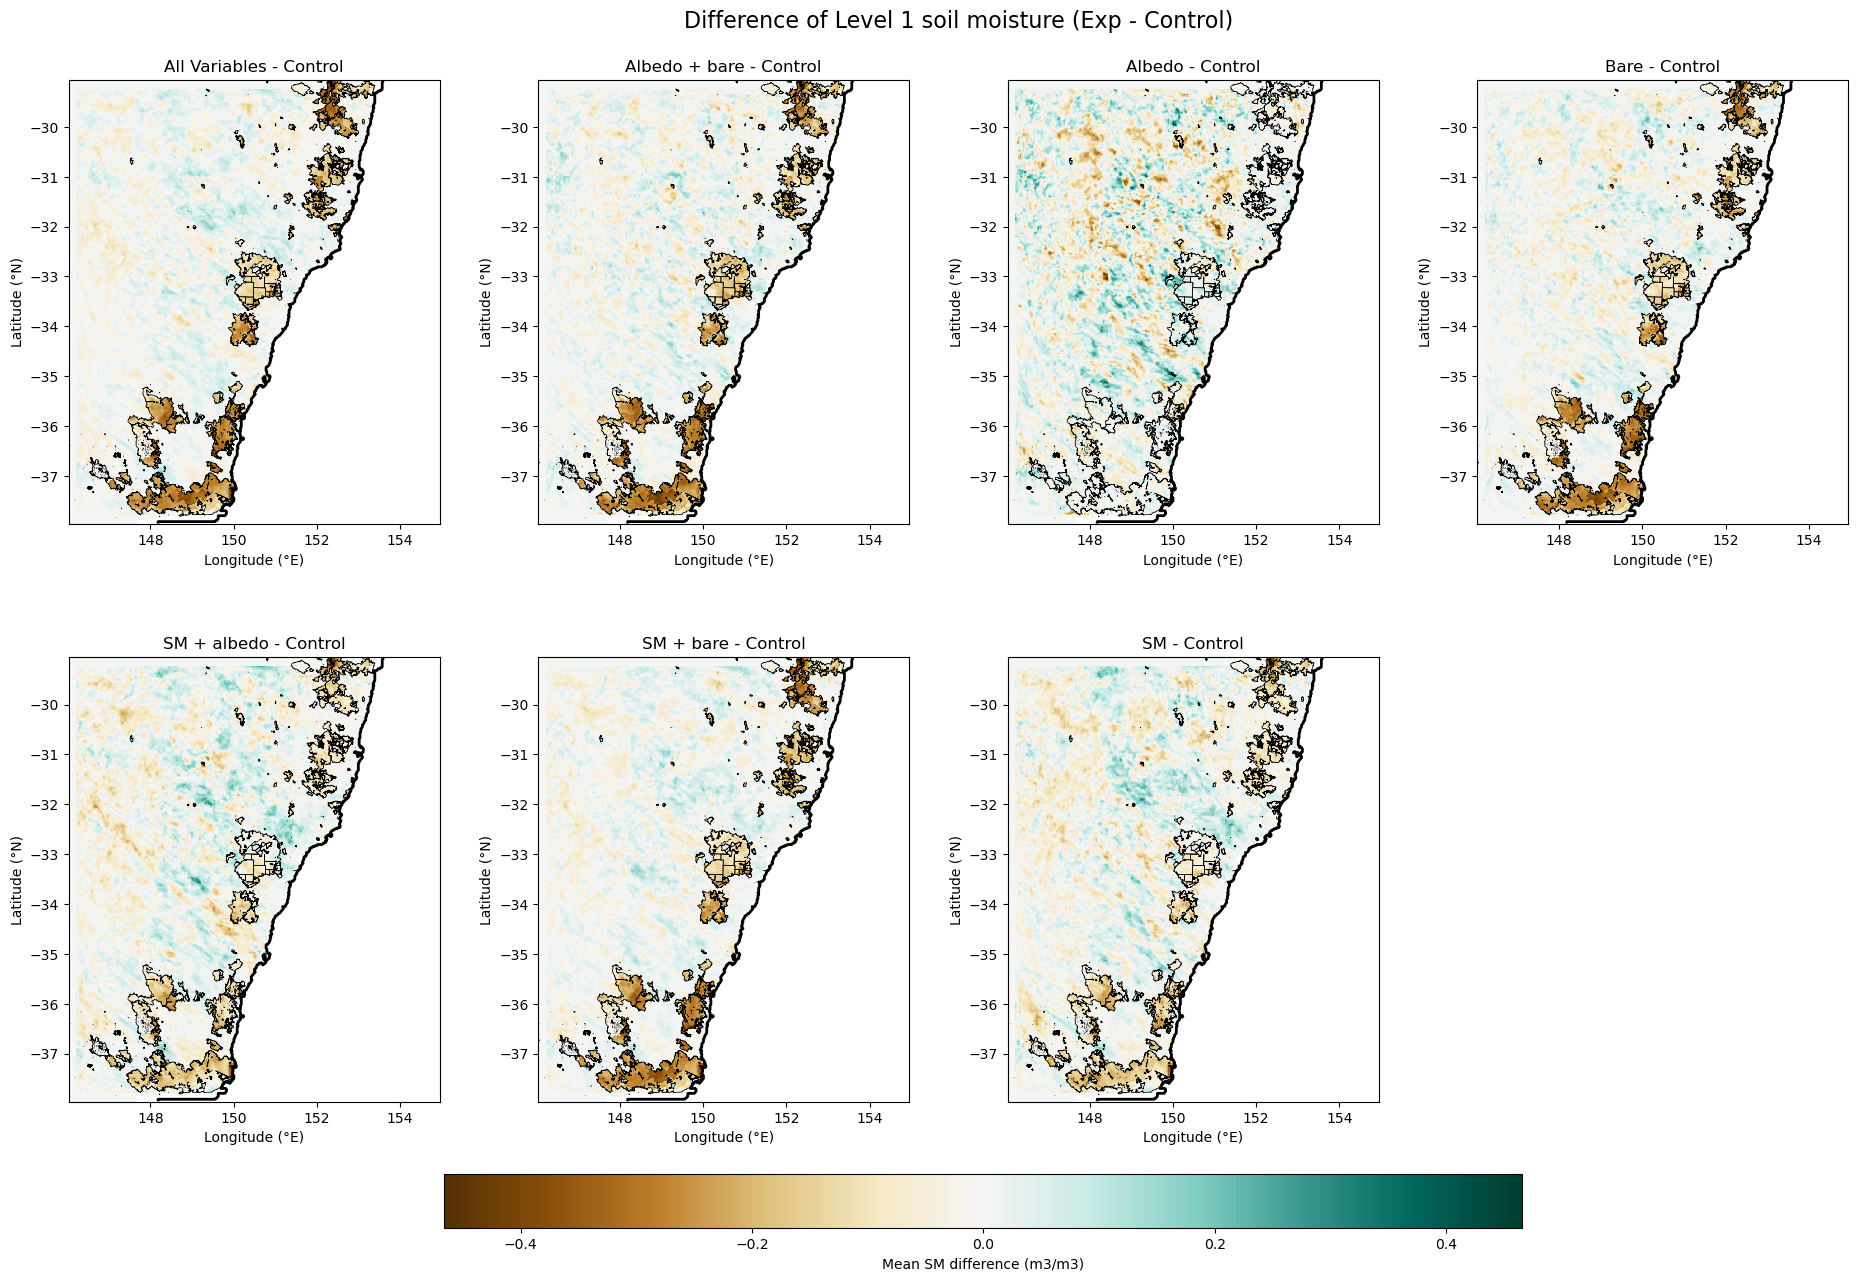

In [6]:
#mean diff from control total time
totals = {
    "All Variables": allvar_total,
    "Control": control_total,
    "Albedo + bare": albedo_bare_total,
    "Albedo": albedo_total,
    "Bare": bare_total,
    "SM + albedo": SM_albedo_total,
    "SM + bare": SM_bare_total,
    "SM": SM_total,
}

names = list(totals.keys())
ref_index = 1 #index of ref, 0 for allvar
ref_name = names[ref_index]

ncols = 4
nrows = 2

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 14))
axes = axes.flatten()

plot_idx = 0
cbar_ax = None 

for i, name in enumerate(names):
    if i == ref_index:
        continue  #skip reference 

    diff = totals[name] - totals[ref_name] 
    ax = axes[plot_idx]

    mesh = diff.plot(
        ax=ax,
        cmap="BrBG",
        center=0,
        extend="both",
        add_colorbar=False
    )

    if plot_idx == 0:
        cbar_ax = mesh 

    #add fires and sea level
    sa1.plot.contour(ax=ax, levels=[0], colors="black", linewidths=2, add_colorbar=False)
    gpd.GeoSeries(fires.boundary).plot(ax=ax, edgecolor="black", linewidth=0.5)

    ax.set_title(f"{name} - {ref_name}")
    ax.set_xlabel("Longitude (°E)", fontsize=10)
    ax.set_ylabel("Latitude (°N)", fontsize=10)

    plot_idx += 1

#remove 8th subplot
for j in range(plot_idx, len(axes)):
    fig.delaxes(axes[j])

fig.colorbar(
    cbar_ax, ax=axes[:plot_idx],
    orientation='horizontal',
    fraction=0.05, 
    pad=0.02,     
    label="Mean SM difference (m3/m3)"
)

# adjust subplot spacing
fig.subplots_adjust(left=0.05, right=0.95, top=0.93, bottom=0.20, hspace=0.3, wspace=0.2)

fig.suptitle(f"Difference of {SM_level} soil moisture (Exp - {ref_name})", fontsize=16)
plt.show()


# movement over time

## daily

In [7]:
#clipping to fires
experiments = {
    "All variables": allvar,
    "Control": control,
    "Albedo + bare": albedo_bare,
    "Albedo": albedo,
    "Bare": bare,
    "SM + albedo": SM_albedo,
    "SM + bare": SM_bare,
    "SM": SM
}

fires = fires.to_crs("EPSG:7844")

clipped = {}

for name, da in experiments.items():
    da = da.rio.write_crs("EPSG:7844")
    
    clipped_da = da.rio.clip(fires.geometry, fires.crs, drop=True, invert=False)
    
    clipped[name] = clipped_da

In [9]:
allvar_f = clipped['All variables']
control_f =clipped['Control']
albedo_bare_f =clipped['Albedo + bare']
albedo_f =clipped['Albedo']
bare_f =clipped['Bare']
SM_albedo_f =clipped['SM + albedo']
SM_bare_f =clipped['SM + bare']
SM_f =clipped['SM']

In [10]:
#fire dict
experiments_f = {
    "All Variables": allvar_f,
    "Control": control_f,
    "Albedo + Bare": albedo_bare_f,
    "Albedo": albedo_f,
    "Bare": bare_f,
    "SM + Albedo": SM_albedo_f,
    "SM + Bare": SM_bare_f,
    "SM": SM_f
}

In [11]:
#daily mean
daily_mean_f = {}
for name, da in experiments_f.items():
    daily_mean_f[name] = da.resample(time="1D").mean()

#flatten
daily_mean_flat_f = {}
for name, da in daily_mean_f.items():
    #flatten spatially
    vals_f = da.values.flatten()
    #remove nan
    daily_mean_flat_f[name] = vals_f[~np.isnan(vals_f)]

#diff from ref
ref_name_f = "Control"
ref_f = daily_mean_f[ref_name_f]

diff_f = {}
for name, da in daily_mean_f.items():
    if name != ref_name_f:
        diff_f[name] = da - ref_f

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _va

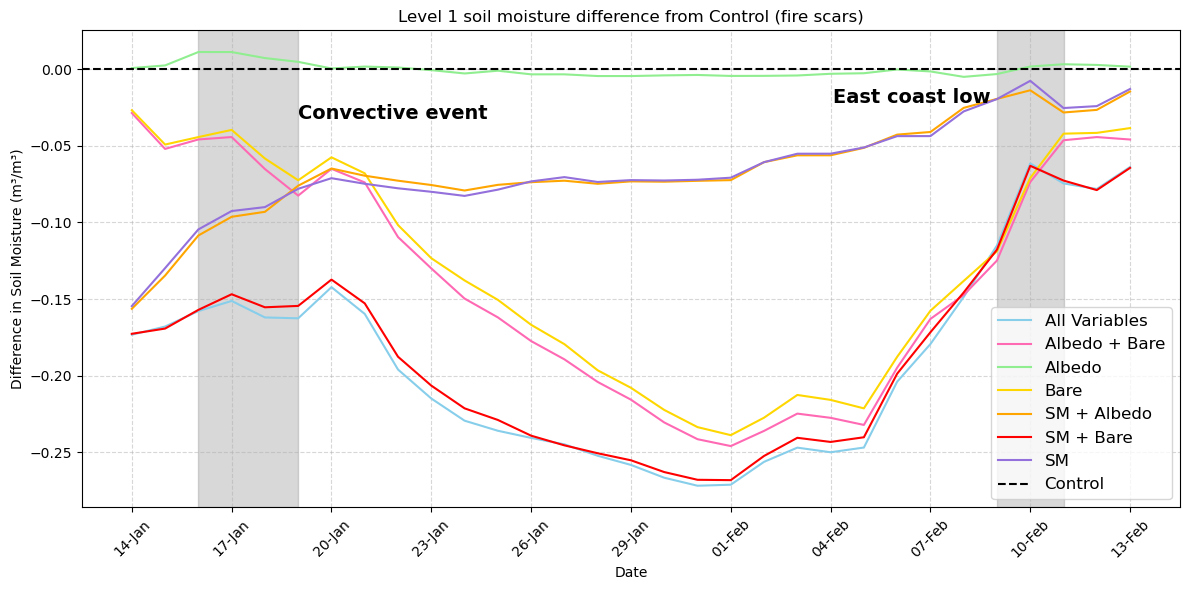

Mann-Whitney U test vs Control (p < 0.05 = significant):
All Variables vs Control: p = 0.000e+00 → Significant
Albedo + Bare vs Control: p = 0.000e+00 → Significant
Albedo vs Control: p = 9.166e-01 → Not significant
Bare vs Control: p = 0.000e+00 → Significant
SM + Albedo vs Control: p = 0.000e+00 → Significant
SM + Bare vs Control: p = 0.000e+00 → Significant
SM vs Control: p = 0.000e+00 → Significant


In [12]:
#plot diff from ctrl
ref_name_f = "Control"
colors = ["skyblue", "hotpink", "lightgreen", "gold", "orange", "red", "mediumpurple", "pink"]

plt.figure(figsize=(12,6))

for i, (name, da) in enumerate(diff_f.items()):
    #spatial mean 
    time_series = da.mean(dim=["latitude","longitude"], skipna=True)
    plt.plot(time_series.time, time_series, label=name, color=colors[i % len(colors)])

#highlights around prominent period
#ECL
start_highlight1 = pd.to_datetime("2020-02-09")  
end_highlight1   = pd.to_datetime("2020-02-11")
plt.axvspan(start_highlight1, end_highlight1, color="grey", alpha=0.3)
plt.text(start_highlight1, plt.ylim()[1]*-0.5, "East coast low ", 
         rotation=0, va="top", ha="right", fontsize=14, color="black", weight='demi')
#Convective
start_highlight2 = pd.to_datetime("2020-01-16") 
end_highlight2   = pd.to_datetime("2020-01-19")
plt.axvspan(start_highlight2, end_highlight2, color="grey", alpha=0.3)

plt.text(end_highlight2, plt.ylim()[1]*-0.9, "Convective event",
         rotation=0, va="top", ha="left", fontsize=14, color="black", weight='demi')

#custom for control
plt.axhline(0, color='k', linestyle='--')
plt.ylabel("Difference in Soil Moisture (m³/m³)")
plt.xlabel("Date")
plt.title(f"{SM_level} soil moisture difference from {ref_name} (fire scars)")
plt.legend()

dates = pd.to_datetime(time_series.time.values)
plt.xticks(ticks=time_series.time.values[::max(1, len(dates)//10)],
           labels=[d.strftime("%d-%b") for d in dates[::max(1, len(dates)//10)]],
           rotation=45)
control_handle = mlines.Line2D([], [], color='k', linestyle='--', label="Control")

plt.legend(handles=[*plt.gca().get_legend_handles_labels()[0], control_handle], loc = 'lower right', fontsize = 12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
# plt.savefig("/g/data/ng72/as9583/figures/SM_lev1_daily.png", dpi=300, bbox_inches="tight")
plt.show()

#significance test
print("Mann-Whitney U test vs Control (p < 0.05 = significant):")
for name, vals in daily_mean_flat_f.items():
    if name != ref_name:
        stat, p = mannwhitneyu(daily_mean_flat_f[ref_name_f], vals)
        sig_text = "Significant" if p < 0.05 else "Not significant"
        print(f"{name} vs {ref_name}: p = {p:.3e} → {sig_text}")

## hourly

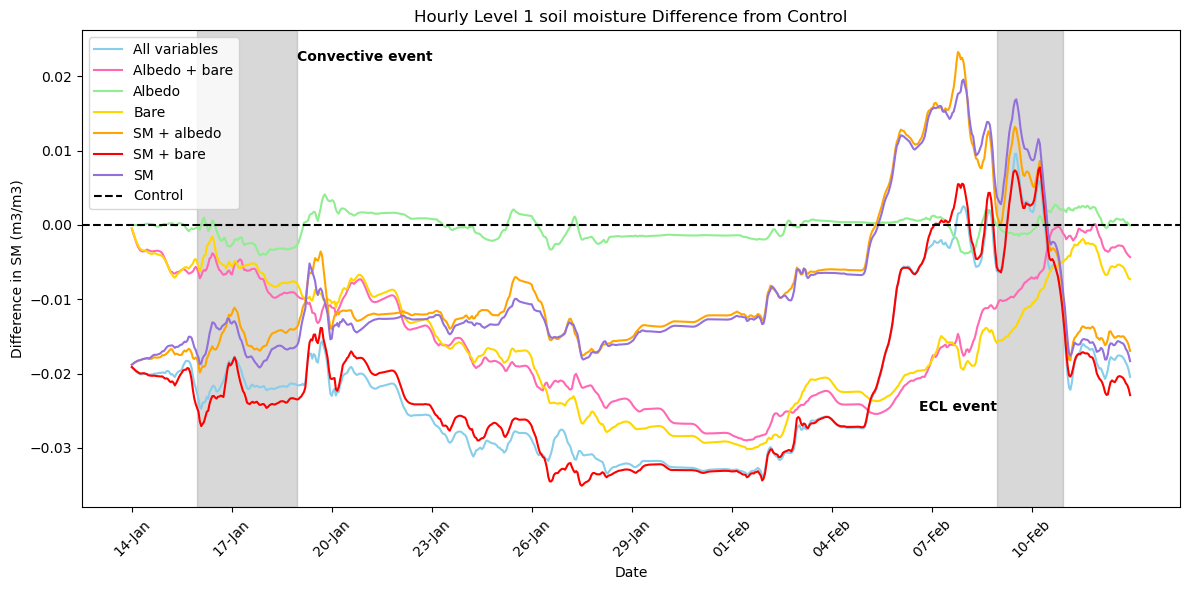

In [14]:
#whole domain
ref_name = "Control"
ref = experiments[ref_name]

#diff from control
diff_hourly = {}
for name, da in experiments.items():
    if name != ref_name:
        diff_hourly[name] = da - ref

colors = ["skyblue", "hotpink", "lightgreen", "gold", 
          "orange", "red", "mediumpurple", "pink"]

plt.figure(figsize=(12,6))

for i, (name, da) in enumerate(diff_hourly.items()):
    #spatial mean each hour
    time_series = da.mean(dim=["latitude","longitude"], skipna=True)
    dates_aest = pd.to_datetime(time_series.time.values) + pd.Timedelta(hours=10)
    plt.plot(dates_aest, time_series, label=name, color=colors[i % len(colors)])

#significant event highlight
#ECL event
plt.axvspan(pd.to_datetime("2020-02-09 00:00") + pd.Timedelta(hours=10),
            pd.to_datetime("2020-02-10 23:59") + pd.Timedelta(hours=10),
            color="grey", alpha=0.3)
plt.text(pd.to_datetime("2020-02-09 00:00") + pd.Timedelta(hours=10),
         plt.ylim()[1]*-0.9, "ECL event", va="top", ha="right", fontsize=10, color="black", weight='demi')
#convective event
plt.axvspan(pd.to_datetime("2020-01-16 00:00") + pd.Timedelta(hours=10),
            pd.to_datetime("2020-01-18 23:59") + pd.Timedelta(hours=10),
            color="grey", alpha=0.3)
plt.text(pd.to_datetime("2020-01-18 23:59") + pd.Timedelta(hours=10),
         plt.ylim()[1]*0.9, "Convective event", va="top", ha="left", fontsize=10, color="black", weight='demi')

#baseline for control
plt.axhline(0, color='k', linestyle='--')
control_handle = mlines.Line2D([], [], color='k', linestyle='--', label="Control")

plt.ylabel("Difference in SM (m3/m3)")
plt.xlabel("Date")
plt.title(f"Hourly {SM_level} soil moisture Difference from {ref_name}")
plt.legend(handles=[*plt.gca().get_legend_handles_labels()[0], control_handle], loc="upper left")

#format x labels
plt.xticks(
    ticks=dates_aest[::max(1, len(dates_aest)//10)],
    labels=[d.strftime("%d-%b") for d in dates_aest[::max(1, len(dates_aest)//10)]],
    rotation=45
)

plt.tight_layout()
plt.show()

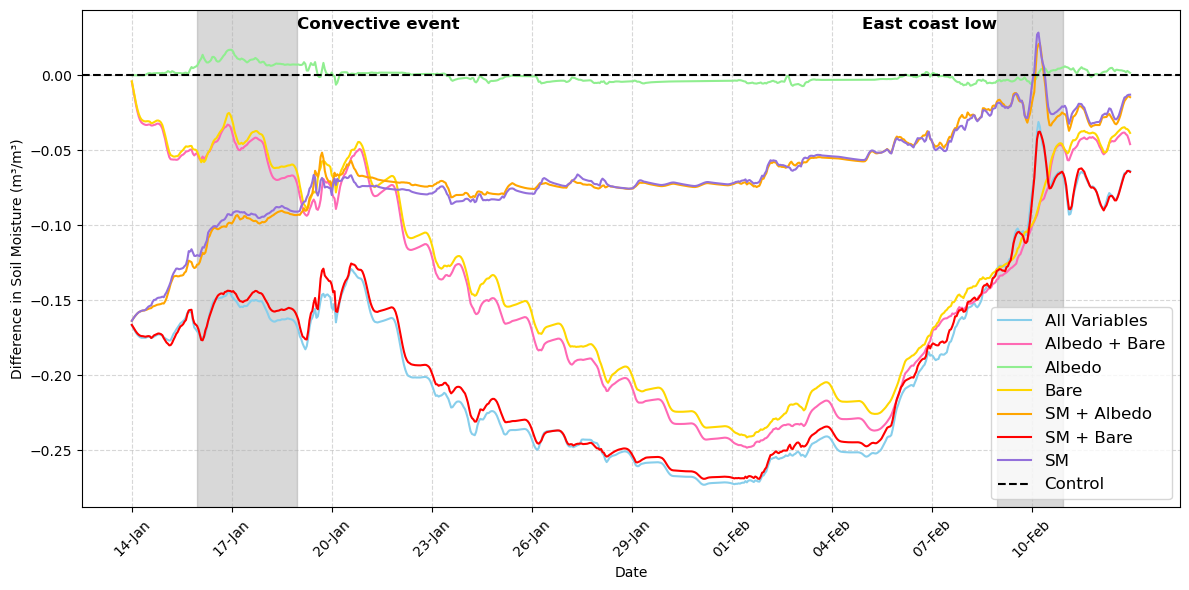

In [15]:
#fire scars
ref_name = "Control"
ref = experiments_f[ref_name]

#diff from control
diff_hourly = {}
for name, da in experiments_f.items():
    if name != ref_name:
        diff_hourly[name] = da - ref

colors = ["skyblue", "hotpink", "lightgreen", "gold", 
          "orange", "red", "mediumpurple", "pink"]

plt.figure(figsize=(12,6))

for i, (name, da) in enumerate(diff_hourly.items()):
    #spatial mean
    time_series = da.mean(dim=["latitude","longitude"], skipna=True)
    dates_aest = pd.to_datetime(time_series.time.values) + pd.Timedelta(hours=10)
    plt.plot(dates_aest, time_series, label=name, color=colors[i % len(colors)])

#highlight events
#ECL
plt.axvspan(pd.to_datetime("2020-02-09 00:00") + pd.Timedelta(hours=10),
            pd.to_datetime("2020-02-10 23:59") + pd.Timedelta(hours=10),
            color="grey", alpha=0.3)
plt.text(pd.to_datetime("2020-02-09 00:00") + pd.Timedelta(hours=10),
         plt.ylim()[1]*0.9, "East coast low", va="top", ha="right", fontsize=12, color="black", weight='demi')
#convective 
plt.axvspan(pd.to_datetime("2020-01-16 00:00") + pd.Timedelta(hours=10),
            pd.to_datetime("2020-01-18 23:59") + pd.Timedelta(hours=10),
            color="grey", alpha=0.3)
plt.text(pd.to_datetime("2020-01-18 23:59") + pd.Timedelta(hours=10),
         plt.ylim()[1]*0.9, "Convective event", va="top", ha="left", fontsize=12, color="black", weight='demi')

#baseline for control
plt.axhline(0, color='k', linestyle='--')
control_handle = mlines.Line2D([], [], color='k', linestyle='--', label="Control")

plt.ylabel("Difference in Soil Moisture (m³/m³)")
plt.xlabel("Date")
# plt.title(f"{SM_level} Hourly Soil Moisture Difference from {ref_name} (fire scars) ")
plt.legend(handles=[*plt.gca().get_legend_handles_labels()[0], control_handle], loc="lower right", fontsize = 12)
plt.grid(True, linestyle="--", alpha=0.5)

#x axis format
plt.xticks(
    ticks=dates_aest[::max(1, len(dates_aest)//10)],
    labels=[d.strftime("%d-%b") for d in dates_aest[::max(1, len(dates_aest)//10)]],
    rotation=45
)

plt.tight_layout()
# plt.savefig("/g/data/ng72/as9583/new_analysis/figures/SM_lev1_hourly_diff.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
## difference in 0.1 or more of SM is significant

## absolute SM

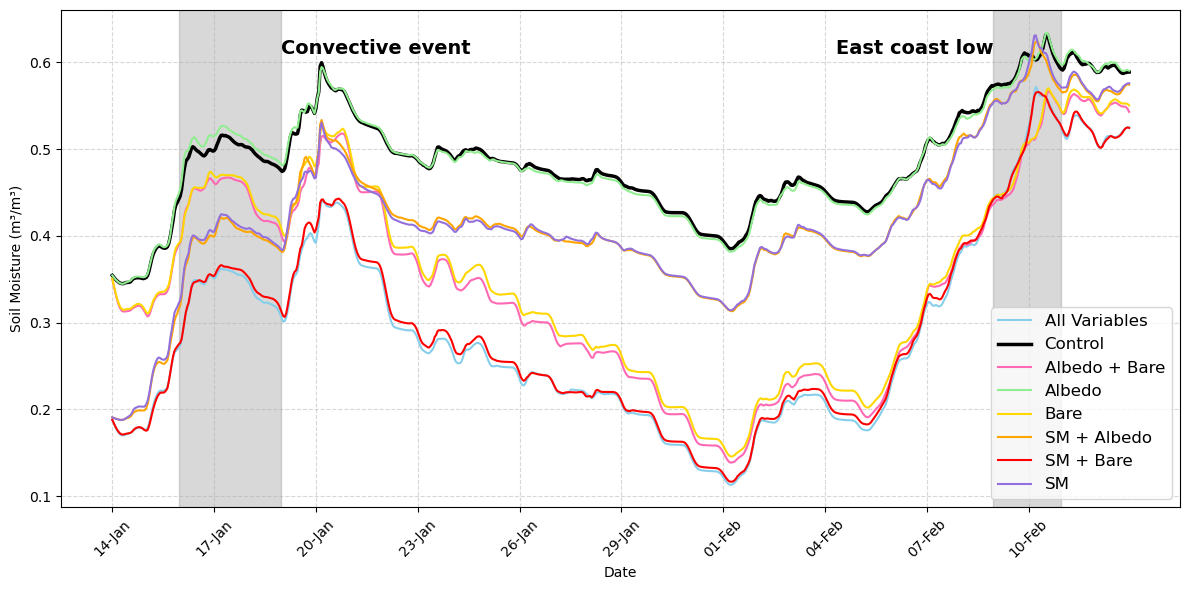

In [16]:
#absolute SM
colors = ["skyblue", "black", "hotpink", "lightgreen", "gold", 
          "orange", "red", "mediumpurple"]

plt.figure(figsize=(12,6))

for i, (name, da) in enumerate(experiments_f.items()):
    #spatial mean
    time_series = da.mean(dim=["latitude","longitude"], skipna=True)
    dates_aest = pd.to_datetime(time_series.time.values) + pd.Timedelta(hours=10)
    # plt.plot(dates_aest, time_series, label=name, color=colors[i % len(colors)])

    # Make Control line thicker
    if name == "Control":
        plt.plot(dates_aest, time_series, label=name, color="black", linewidth=2.5)
    else:
        plt.plot(dates_aest, time_series, label=name, color=colors[i % len(colors)], linewidth=1.5)

#highlight events
#ECL
plt.axvspan(pd.to_datetime("2020-02-09 00:00") + pd.Timedelta(hours=10),
            pd.to_datetime("2020-02-10 23:59") + pd.Timedelta(hours=10),
            color="grey", alpha=0.3)
plt.text(pd.to_datetime("2020-02-09 00:00") + pd.Timedelta(hours=10),
         plt.ylim()[1]*0.95, "East coast low", va="top", ha="right", fontsize=14, color="black", weight="demi")
#convective 
plt.axvspan(pd.to_datetime("2020-01-16 00:00") + pd.Timedelta(hours=10),
            pd.to_datetime("2020-01-18 23:59") + pd.Timedelta(hours=10),
            color="grey", alpha=0.3)
plt.text(pd.to_datetime("2020-01-18 23:59") + pd.Timedelta(hours=10),
         plt.ylim()[1]*0.95, "Convective event", va="top", ha="left", fontsize=14, color="black", weight="demi")

plt.ylabel("Soil Moisture (m³/m³)")
plt.xlabel("Date")
# plt.title(f"{SM_level} Hourly Soil Moisture (fire scars)")
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)

plt.xticks(
    ticks=dates_aest[::max(1, len(dates_aest)//10)],
    labels=[d.strftime("%d-%b") for d in dates_aest[::max(1, len(dates_aest)//10)]],
    rotation=45
)

plt.tight_layout()
# plt.savefig("/g/data/ng72/as9583/new_analysis/figures/SM_lev1_hourly_raw.png", dpi=300, bbox_inches="tight")
plt.show()
